In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import data
import viz
from viz import *
outcome_def = 'iai_intervention' # output
%matplotlib inline
%load_ext autoreload
%autoreload 2

# combined

In [3]:
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
# df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats,
                                          collapse_abd_tender=True,
                                          collapse_abd_distention=True)
df_pecarn = df_pecarn[df_pecarn.cv_fold.isin(data.pecarn_train_idxs)]
df = df_pecarn[common_feats]
# df_psrc = df_psrc[df_psrc.cv_fold.isin(data.psrc_train_idxs)]
print(processed_feats)

/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


['AbdDistention_or_AbdomenPain_yes', 'AbdTenderDegree_None', 'AbdTrauma_or_SeatBeltSign_yes', 'Age<2_yes', 'CostalTender_yes', 'DecrBreathSound_yes', 'GCSScore_Full_yes', 'Hypotension_yes', 'MOI_Bike collision/fall', 'MOI_Fall from an elevation', 'MOI_Motor vehicle collision', 'MOI_Motorcycle/ATV/Scooter collision', 'MOI_Object struck abdomen', 'MOI_Pedestrian/bicyclist struck by moving vehicle', 'ThoracicTrauma_yes', 'VomitWretch_yes']


**correlations between features**

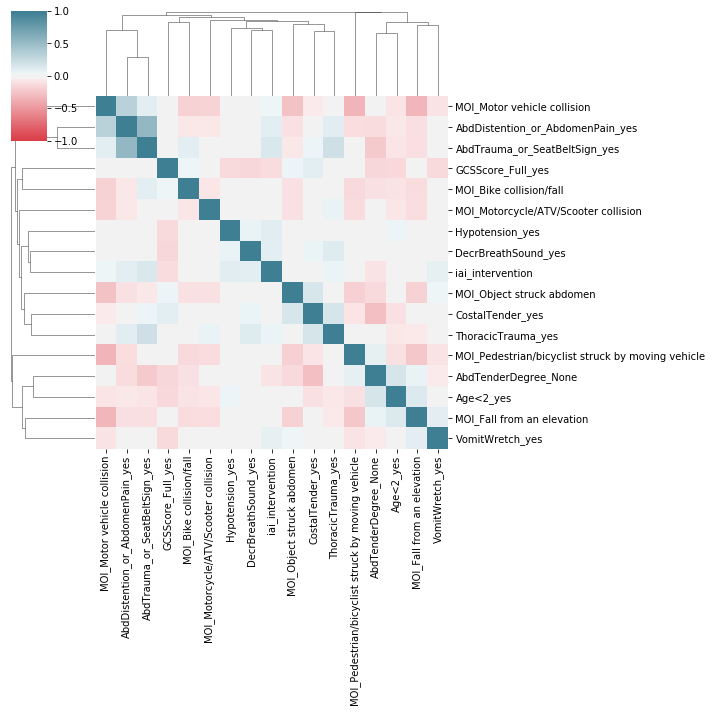

In [57]:
# corrs = df[feat_names + [outcome_def]].corr()
corrs = df[processed_feats + [outcome_def]].corr(method='pearson')
sns.clustermap(corrs, cmap=viz.cmap_div, vmin=-1, vmax=1)
plt.show()
# plt.savefig('results/corrplot.png', dpi=300, bbox_inches='tight')

**individual correlations with outcome**

In [ ]:
plt.figure(dpi=250, figsize=(4, 7))
vals = corrs[outcome_def]
args = np.argsort(vals)
labs = corrs['iai_intervention'][args].index.values
ax = plt.subplot(111)
plt.barh(labs[:-1], vals[args][:-1])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

**binary proportions with outcome**

In [ ]:
plt.figure(dpi=250, figsize=(4, 7))
ks = np.array(processed_feats)
vals = np.array([np.mean(df[outcome_def][df[k] == 1]) for k in ks])
counts = np.array([np.sum([df[k] == 1]) for k in ks])
args = np.argsort(vals)
labs = ks[args]
vals = vals[args]
counts = counts[args]
ax = plt.subplot(111)
plt.barh(labs, vals)
for i, (v, c) in enumerate(zip(vals, counts)):
    ax.text(v, i - 0.1, str(c), color=cg, fontweight='bold')
ax.text(0.05, 1, 'Count in subgroup', color=cg, fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Fraction of IAI-I patients')
plt.show()

**joint correlations with outcome joint**

In [ ]:
d = len(processed_feats)
mat = np.zeros((2 * d, 2 * d))
# func = lambda x, y: np.corrcoef(x, y)[0, 1] # corr
func = lambda x, y: np.mean(y[x]) # frac high-risk
y = df[outcome_def]
for r in range(d):
    for c in range(d):
        xr = df[processed_feats[r]] == 1
        xc = df[processed_feats[c]] == 1
        mat[2 * r, 2 * c] = func(xr & xc, y)
        mat[2 * r + 1, 2 * c] = func(~xr & xc, y)
        mat[2 * r, 2 * c + 1] = func(xr & ~xc, y)
        mat[2 * r + 1, 2 * c + 1] = func(~xr & ~xc, y)
        
fs = np.array([[x, '~' + x] for x in processed_feats]).flatten()
mat[np.isnan(mat)] = 0
matt = pd.DataFrame(mat, index=fs, columns=fs)
vabs = np.max([np.abs(np.min(mat)), np.max(mat)])
vmin = -vabs
cmap = viz.cmap_div
if np.min(mat) >= 0:
    vmin = 0
    cmap = 'Blues'
sns.clustermap(matt, cmap=cmap, vmin=vmin, vmax=vabs,
               dendrogram_ratio=0.2, figsize=(10, 10),)
#                row_cluster=False, col_cluster=False)
# plt.savefig('dendrogram.png', dpi=400)
# plt.tight_layout()
plt.show()

# features scatter plots

## continuous features

In [ ]:
R, C, = 1, 4
plt.figure(figsize=(12, 3), dpi=500)
for i in range(len(data.feats_numerical)):
    plt.subplot(R, C, i + 1)
    feat = data.feats_numerical[i]
    plt.hist(df[df[outcome_def] == 1][feat], density=True, alpha=1, label='pos', color=cb)
    plt.hist(df[df[outcome_def] == 0][feat], density=True, alpha=0.5, label='neg', color=cr)
    plt.xlabel(feat, fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

**we can cut GCSScore as whether it is 15 or not (14 is already pretty bad)**

In [ ]:
feat = 'GCSScore'
print(np.unique(df[df[outcome_def] == 1][feat], return_counts=True))
print(np.unique(df[df[outcome_def] == 0][feat], return_counts=True))

## scatter plots

In [ ]:
viz.jointplot_grouped('Age', 'InitSysBPRange', 'iai_intervention', df)

In [8]:
# viz.jointplot_grouped('Age', 'AbdDistention_yes', 'iai_intervention', df)

In [ ]:
viz.jointplot_grouped('InitSysBPRange', 'InitHeartRate', 'iai_intervention', df)

In [ ]:
viz.jointplot_grouped('Age', 'Hypotension_yes', 'iai_intervention', df)

In [ ]:
viz.jointplot_grouped('Age', 'Sex_M', 'iai_intervention', df_pecarn) # this is using the df that still has gender